In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# datos


**usarios con Control** = 0

**usarios con Depresión** = 1


**usarios con Ansiedad** = 2

**PREPARACIÓN DE DATOS**

*Cargar y limpiar*

In [ ]:
!pip install pyspellchecker
!pip install spacy
!python -m spacy download es_core_news_sm

In [ ]:
import string
import re
import os
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# limpiar texto y Crear Tokens

In [ ]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def load_doc(filename):
    try:
        data = pd.read_csv(filename, delimiter='\t')  # Indicamos el delimitador como '\t' para TSV
        return data
    except Exception as e:
        print("Error:", e)
        return None

#Creamos un función de limpieza del texto y  los guarde en tokens indivicuales o lista de palabras
def clean_doc(text):
    # Eliminar hashtags
    text = re.sub(r'#\w+', '', text)

    # Eliminar URLs o enlaces
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

    # Eliminar nombres de usuarios de Twitter
    text = re.sub(r'@\w+', '', text)

    # Eliminar Nombres propios
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

    # Eliminar todos los caracteres especiales
    text = re.sub(r'[^\w\s]+', '', text)

    # Eliminar prefijos y números
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

    # Eliminar palabras específicas
    specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                      'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                      'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                      'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                      'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                      'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                      'it','we','they','the','and','that','these','those','tweet','followed','follower']
    text = ' '.join([word for word in text.split() if word not in specific_words])

    # Eliminar emojis
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                 '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                 ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')

    # Convertir el texto a minúsculas
    text = text.lower()

    # Eliminar signos de puntuación
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenización de palabras
    tokens = word_tokenize(text)

    # Eliminar palabras vacías en español
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if not word in stop_words]

    # Eliminar tokens de un solo carácter
    tokens = [word for word in tokens if len(word) > 1]

    return tokens


In [ ]:
# #Aplicamos las funciones ya creadas en el conjunto de datos de depresión
# # Cargar el archivo CSV en un DataFrame
# filename = '/content/drive/MyDrive/base de datos/Cont/90_usuarios_de_control.csv'
# data = load_doc(filename)

# # Aplicar la limpieza de texto a la columna "TWEET_TEXT" y mostrar los tokens
# data['TWEET_tokens'] = data['TWEET_TEXT'].apply(clean_doc)
# print(data['TWEET_tokens'])

*Extraer y Definir vocabulario*

In [ ]:
# Función para agregar tokens al vocabulario a partir de un archivo csv
def add_doc_vocab_from(filename, vocab):
    data = pd.read_csv(filename, sep=',')  # Especificamos el separador
    tokens_list = data['tweet'].apply(clean_doc)
    for tokens in tokens_list:
        vocab.update(tokens)

# Función para procesar documentos en un directorio a partir de archivos csv
def process_docs_in_directory(directory, vocab):
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):  # Verificamos si el archivo tiene extensión .csv
            path = os.path.join(directory, filename)
            add_doc_vocab_from(path, vocab)

In [ ]:
# Inicializar el contador de vocabulario
vocab = Counter()
# Procesar documentos en el directorio 'Control'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de control 2/', vocab)
# Procesar documentos en el directorio 'Ansiedad'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/', vocab)
# Procesar documentos en el directorio 'Depresión'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de depresión 2/', vocab)
# Imprimir la longitud del vocabulario y los 50 tokens más comunes
print(f'Tokens totales: {len(vocab)}')
print('los 50 Tokens más frecuentes')
print(vocab.most_common(50))


Tokens totales: 100085
los 50 Tokens más frecuentes
[('httpurl', 45669), ('ser', 6363), ('bien', 6156), ('así', 5263), ('quiero', 5254), ('vida', 4876), ('día', 4794), ('solo', 4773), ('ver', 4681), ('voy', 4438), ('hace', 4367), ('gente', 4267), ('siempre', 4208), ('hacer', 4203), ('mejor', 4197), ('tan', 4149), ('vez', 3914), ('ahora', 3755), ('hoy', 3574), ('amo', 3485), ('mas', 3422), ('años', 3402), ('cosas', 3262), ('mal', 3258), ('puede', 2916), ('puedo', 2916), ('tener', 2828), ('verdad', 2730), ('nunca', 2594), ('gracias', 2548), ('alguien', 2515), ('menos', 2485), ('dos', 2427), ('días', 2425), ('mismo', 2339), ('cada', 2262), ('casa', 2250), ('cómo', 2247), ('bueno', 2230), ('tiempo', 2220), ('cuenta', 2218), ('amor', 2212), ('después', 2169), ('siento', 2122), ('personas', 2110), ('nadie', 2096), ('decir', 2090), ('veces', 2087), ('ganas', 2072), ('mundo', 2062)]


In [ ]:
#Reducimos el numero de tokens eliminando Tokens que solo tengan 2 o menos frecuencia en las bases de datos
umbral = 10 # elimanamos la palabras que tengan 50 o menos frecuencia
tokens =[k for k,c in vocab.items() if c >= umbral]
print(len(tokens))

13358


In [ ]:
# Función para guardar los tokens en una lista de palabras
#guardar archivo preparado
def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename,'w')
  file.write(data)
  file.close()

In [ ]:
#Guardar los tokens en una lista de palabra o bolsa de palabras en un archivo llamdo vocab.txt
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# Inicializar el contador de vocabulario
vocab = Counter()
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de control 2/', vocab)
# Procesar documentos en el directorio 'Ansiedad'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/', vocab)
# Procesar documentos en el directorio 'Depresión'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de depresión 2/', vocab)
print(f'Vocabulario: {len(vocab)}')
umbral = 10 # elimanamos la palabras que tengan 10 o menos frecuencia
tokens =[k for k,c in vocab.items() if c >= umbral]
print(f'Vocabulario con tokens más frecuentes:{len(tokens)}')

#Guardar la lista de Vocabulario con los tokens más frecuentes
save_list(tokens, '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt')


Vocabulario: 100085
Vocabulario con tokens más frecuentes:13358


In [ ]:
archivo = open("/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt")
print(archivo.read())

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")
# Función para lematizar y extraer términos

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def extractTerms(text):
    # Tokenización y lematización con spaCy
    doc = nlp(text)
    lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

    return lemmatized_terms

**Representación de bolsa de palabras (representación vectorial)**

*Revisiones a Lineas de Tokens*

In [ ]:
def doc_to_line(filename, vocab):
  doc = load_doc(filename)
  tokens = clean_doc(doc)
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

In [ ]:
import os
import pandas as pd
from nltk.classify.senna import path

def process_docs(directory, vocab):
    lines = []
    for filename in os.listdir(directory):
        if not filename.endswith('.csv'):
            continue
        path = os.path.join(directory, filename)

        # Cargar el archivo en un DataFrame
        data = pd.read_csv(path, sep=',')  # Usamos sep=',' para especificar que el archivo es tsv

        # Procesar la columna TWEET_TEXT para obtener los tokens
        tokens_list = data['tweet'].apply(clean_doc)
        #tokens_list = data['TWEET_TEXT'].apply(extractTerms)

        for tokens in tokens_list:
            line = ' '.join(tokens)
            lines.append(line)

    return lines

In [ ]:
def load_clean_dataset(vocab):
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de control 2/',vocab)
  Ans = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/',vocab)
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de depresión 2/',vocab)
  docs = Ans + Cont + Dep

  labels = [1 for _ in range(len(Ans))] + [2 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))]
  return docs, labels

In [ ]:
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt'
with open(vocab_filename, 'r') as file:
    vocab_content = file.read()

vocab = vocab_content.split()
vocab = set(vocab)
print(vocab)


*Revisiones de los tweets a vectores de bolsa de palabras*

In [ ]:
# implementamos todo pero usando directamente las funciones creadas
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

docs, labels = load_clean_dataset(vocab)
print(len(docs), len(labels))

197248 197248


**Convertir y tranformar el documento a vectores codigicados**

In [ ]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        if is_train and filename.startswith('(72)'):
            continue  # Omitir archivos de prueba en el conjunto de entrenamiento
        if not is_train and not filename.startswith('(72)'):
            continue  # Omitir archivos de entrenamiento en el conjunto de prueba
        path = os.path.join(directory, filename)
        doc = load_doc(path)
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

In [ ]:
import array
#Del mismo modo, la función load_clean_dataset() debe actualizarse para cargar el entrenamiento o prueba
# y asegúrarse de que devuelva una matriz Numpy
def load_clean_dataset(vocab, is_train):
  Ans = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de control 2/', vocab, is_train)
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de depresión 2/', vocab, is_train)
  docs = Ans + Cont +Dep
  labels = np.array([2 for _ in range(len(Ans))] + [1 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))])
  return docs, labels

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):  # Verificar si es un archivo antes de procesarlo
            doc = load_doc(path)
            line = ' '.join(clean_doc(doc))
            lines.append(line)
    return lines

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text


**Modelo análisis de texto**

In [ ]:
import os
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Cargar los datos limpios (entrenamiento y prueba)
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)


tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='binary')


# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=20)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(189, 106877)
(81, 106877)
(189,)
(81,)


In [ ]:
y_train

array([0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1,
       1, 1, 2, 2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 1, 2,
       0, 1, 2, 2, 2, 1, 2, 0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
       2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 0,
       1, 1, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0,
       2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 1, 2, 0,
       2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2,
       2, 0, 0, 2, 2, 1, 0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0])

In [ ]:
X_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

#Redución de dimensionalidad con LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Aplicar LDA para reducir la dimensionalidad
n_topics = 70  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train = lda.fit_transform(X_train, y_train)
X_val = lda.transform(X_val)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(189, 70)
(81, 70)
(189,)
(81,)


In [ ]:
y_train

array([0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1,
       1, 1, 2, 2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 1, 2,
       0, 1, 2, 2, 2, 1, 2, 0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
       2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 0,
       1, 1, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0,
       2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 1, 2, 0,
       2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2,
       2, 0, 0, 2, 2, 1, 0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0])

In [ ]:
X_train

array([[5.25596552e-06, 5.25596552e-06, 5.25596552e-06, ...,
        5.25596552e-06, 5.25596552e-06, 5.25596552e-06],
       [7.60282825e-06, 7.60282825e-06, 7.60282825e-06, ...,
        7.60282825e-06, 7.60282825e-06, 7.60282825e-06],
       [4.55975560e-06, 4.55975560e-06, 4.55975560e-06, ...,
        4.55975560e-06, 4.55975560e-06, 4.55975560e-06],
       ...,
       [5.13320671e-06, 5.13320671e-06, 5.13320671e-06, ...,
        5.13320671e-06, 5.13320671e-06, 5.13320671e-06],
       [3.99936010e-06, 3.99936010e-06, 3.99936010e-06, ...,
        3.99936010e-06, 3.99936010e-06, 3.99936010e-06],
       [8.79662210e-06, 8.79662210e-06, 8.79662210e-06, ...,
        8.79662210e-06, 8.79662210e-06, 8.79662210e-06]])

#Red neuronal

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización
# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características en X_train
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(264, activation='relu'))
model.add(Dropout(0.2))  # Dropout para regularización
# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.2))  # Dropout para regularización
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.2))  # Dropout para regularización

# Agregar una capa de salida con el número de clases en tu clasificación multiclase
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=30, validation_data=(X_val, y_val_one_hot))

y_val_pred = model.predict(X_val)

y_val_pred_class = y_val_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_val_true_class = y_val_one_hot.argmax(axis=1)  # Usar y_val_one_hot en lugar de y_val si está codificado en one-hot

accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

y_train_pred = model.predict(X_train)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred_class = y_train_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_train_true_class = y_train_one_hot.argmax(axis=1)  # Usar y_train_one_hot en lugar de y_train si está codificado en one-hot

accuracy_train = accuracy_score(y_train_true_class, y_train_pred_class)
precision_train = precision_score(y_train_true_class, y_train_pred_class, average='macro')
recall_train = recall_score(y_train_true_class, y_train_pred_class, average='macro')
f1_train = f1_score(y_train_true_class, y_train_pred_class, average='macro')

Epoch 1/50
7/7 [==============================] - 1s 39ms/step - loss: 1.0999 - categorical_accuracy: 0.3704 - val_loss: 1.1001 - val_categorical_accuracy: 0.3210
Epoch 2/50
7/7 [==============================] - 0s 10ms/step - loss: 1.0874 - categorical_accuracy: 0.4021 - val_loss: 1.1025 - val_categorical_accuracy: 0.3210
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 1.0747 - categorical_accuracy: 0.3862 - val_loss: 1.1095 - val_categorical_accuracy: 0.3951
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 1.0639 - categorical_accuracy: 0.3968 - val_loss: 1.1174 - val_categorical_accuracy: 0.3333
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 1.0304 - categorical_accuracy: 0.4656 - val_loss: 1.1157 - val_categorical_accuracy: 0.3210
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 1.0153 - categorical_accuracy: 0.4815 - val_loss: 1.1381 - val_categorical_accuracy: 0.3210
Epoch 7/50
7/7 [======

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 77.0%
Precisión (entrenamiento): 79.0%
Recall (entrenamiento): 77.0%
F1-score (entrenamiento): 76.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 56.99999999999999%
Precisión en el conjunto de validación: 76.0%
Recall en el conjunto de validación: 56.99999999999999%
F1-score en el conjunto de validación: 56.00000000000001%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_true_class, y_train_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)
26 0 2
3 20 5
9 0 19

Matriz de Confusión:
[[58  1  5]
 [ 7 44 11]
 [19  2 42]]


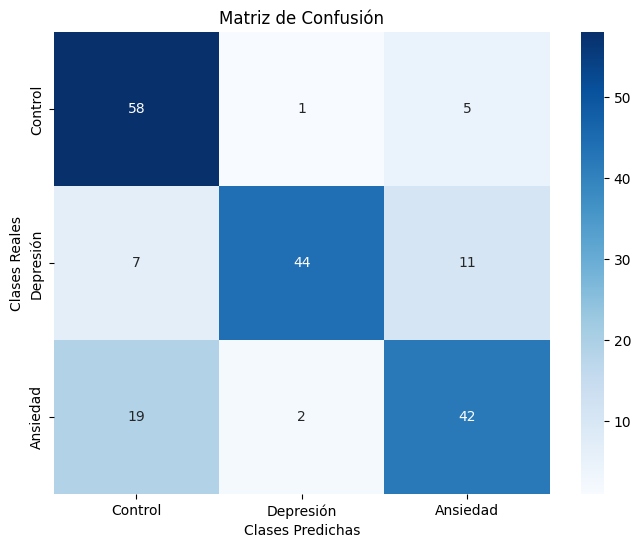

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=1000,  # Número de árboles
    max_depth=1000,  # Profundidad máxima de los árboles
    random_state=20,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)

# Entrena el modelo con los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula e imprime la precisión del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Precisión (Validación): {:.2f}".format(accuracy))

# Calcula e imprime la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precisión (Validación): {:.2f}".format(precision))

# Calcula e imprime la exhaustividad del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Exhaustividad (Validación): {:.2f}".format(recall))

# Calcula e imprime la puntuación F1 del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Puntuación F1 (Validación): {:.2f}".format(f1))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))

Precisión (Validación): 0.43
Precisión (Validación): 0.62
Exhaustividad (Validación): 0.43
Puntuación F1 (Validación): 0.37

Métricas en el conjunto de entrenamiento:
Precisión: 1.00
Exhaustividad: 1.00
Puntuación F1: 1.00


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 100.00%
Precisión  entrenamiento: 100.00%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 100.00%


Accuracy  validación: 43.21%
Precisión  validación: 61.78%
Recall  validación: 43.21%
Puntuación F1 validación: 37.20%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[24  0  2]
 [17  4  7]
 [20  0  7]] 



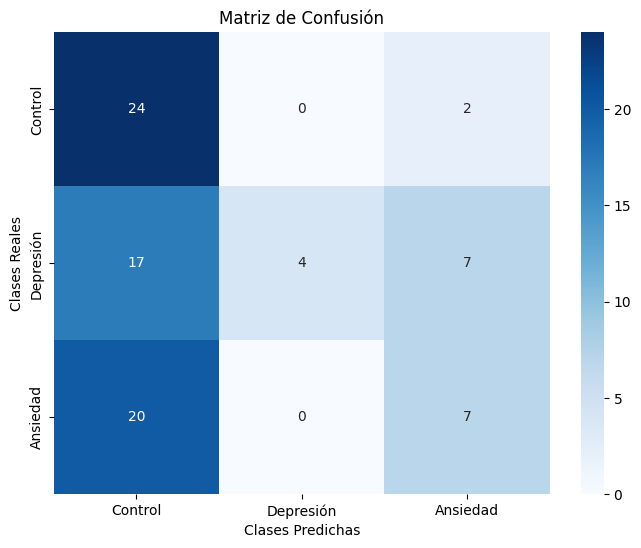

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Suponiendo que ya tienes tus datos de entrenamiento y validación: X_train, X_val, y_train, y_val

# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p = SVC(kernel='sigmoid', C=100, gamma='scale', coef0=2.5)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[15  2  9]
 [ 7 12  9]
 [ 7  1 19]] 



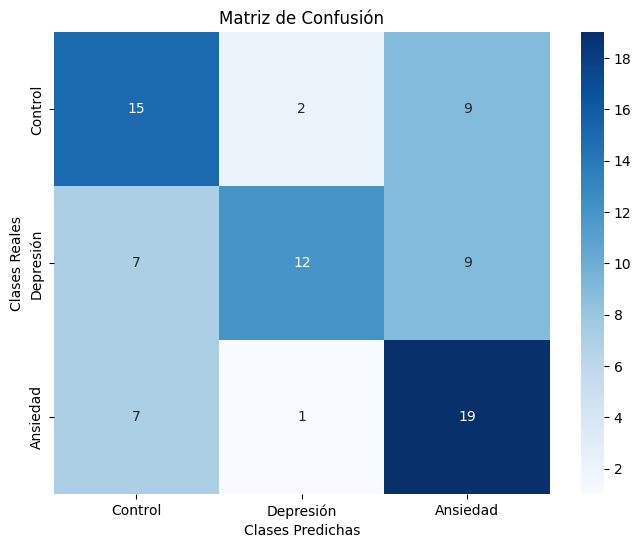

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()